In [1]:
from utils import *
check_tensorflow_gpu()

proxy = SpatiotemporalCO2()
proxy.__dict__

c:\Users\Misael Morales\miniconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Misael Morales\miniconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you 

... Checking Tensorflow Version ...
Tensorflow built with CUDA? True
TF: 2.10.0 | CUDA: 64_112 | cuDNN: 64_8
# GPU available: 1 (NVIDIA GeForce RTX 3080)


{'input_features_dir': 'simulations2D/input_features',
 'output_targets_dir': 'simulations2D/output_targets',
 'n_realizations': 1000,
 'x_channels': 4,
 'y_channels': 2,
 'timesteps': 60,
 'dim': 64,
 'test_size': 0.25,
 't_samples': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60],
 'optimizer': <keras.optimizers.optimizer_v2.nadam.Nadam at 0x22edb919000>,
 'criterion': <bound method SpatiotemporalCO2.custom_loss of <utils.SpatiotemporalCO2 object at 0x0000022E829C5CC0>>,
 'L1L2_split': 0.25,
 'loss_alpha': 0.8,
 'regular': <keras.regularizers.L1 at 0x22edc0cb430>,
 'leaky_slope': 0.25,
 'num_epochs': 100,
 'batch_size': 30,
 'lr_sch_type': 1,
 'lr_decay': 25,
 'verbose': 0}

In [2]:
proxy.load_data()
proxy.process_data(subsample=750)

X: (1000, 64, 64, 4) | y: (1000, 60, 64, 64, 2)
MinMax Normalization Done!
Subsampling data for 750 samples, 11 timesteps ...
Train - X: (562, 64, 64, 4) | y: (562, 11, 64, 64, 2)
Test  - X: (188, 64, 64, 4) | y: (188, 11, 64, 64, 2)


In [3]:
model0 = proxy.make_model()
model0.summary()

Model: "CNN-RNN-Proxy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 4)]       0         
                                                                 
 Encoder (Functional)        (None, 8, 8, 128)         197908    
                                                                 
 Decoder (Functional)        (None, 11, 64, 64, 2)     6819994   
                                                                 
Total params: 7,017,902
Trainable params: 7,017,898
Non-trainable params: 4
_________________________________________________________________


# Parameters: 7,017,902
Epoch: 10 - Loss: 0.3732 - Val Loss: 0.3878
Epoch: 20 - Loss: 0.3564 - Val Loss: 0.3609
Epoch: 30 - Loss: 0.3437 - Val Loss: 0.3508
Epoch: 40 - Loss: 0.3336 - Val Loss: 0.3499
Epoch: 50 - Loss: 0.3212 - Val Loss: 0.3436
Epoch: 60 - Loss: 0.3136 - Val Loss: 0.3376
Epoch: 70 - Loss: 0.3089 - Val Loss: 0.3334
Epoch: 80 - Loss: 0.3051 - Val Loss: 0.3303
Epoch: 90 - Loss: 0.3030 - Val Loss: 0.3290
Epoch: 100 - Loss: 0.3013 - Val Loss: 0.3272
Training Time: 13.37 minutes


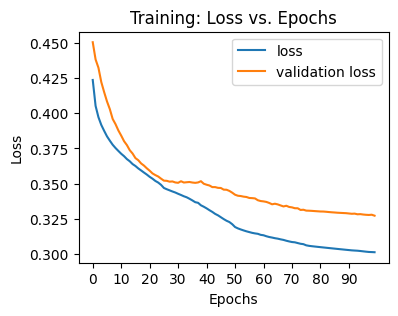

In [4]:
model, fit = proxy.train(model0)

In [5]:
y_train_pred = model.predict(proxy.X_train)
y_test_pred  = model.predict(proxy.X_test)
print('Train pred: {} | Test pred: {}'.format(y_train_pred.shape, y_test_pred.shape))

6/6 [==============================] - 1s 235ms/step
Train pred: (562, 11, 64, 64, 2) | Test pred: (188, 11, 64, 64, 2)


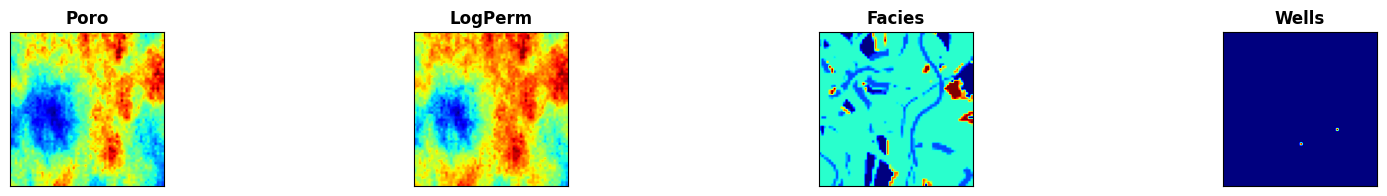

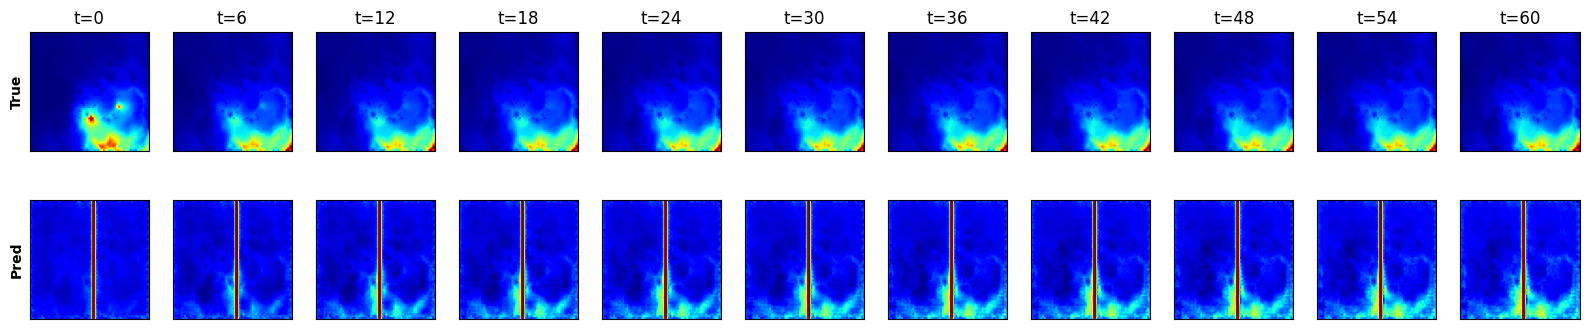

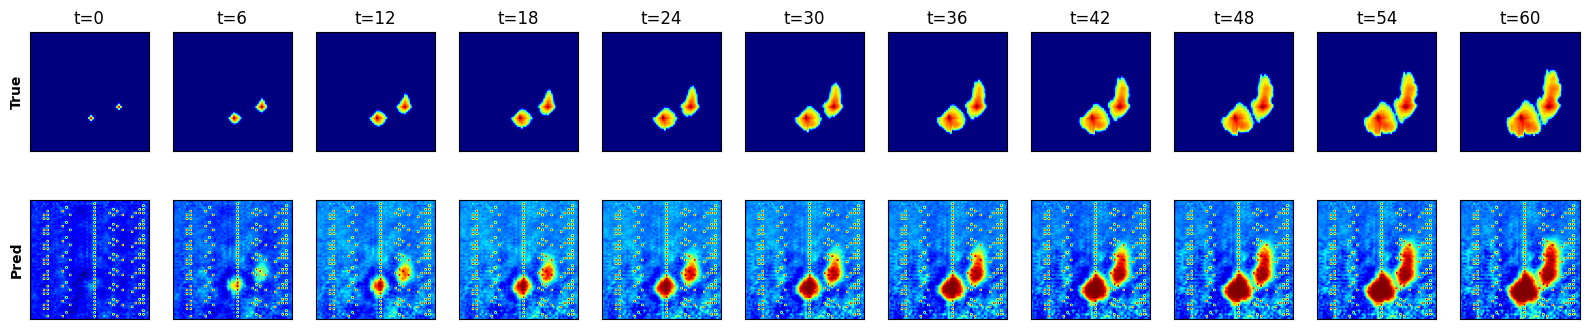

In [11]:
plot_results(151, proxy.X_train, proxy.y_train, y_train_pred, proxy.t_samples)

***
# END